<a href="https://colab.research.google.com/github/omerhac/arc_challenge/blob/master/arc_starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import json
from google.cloud import storage
from matplotlib import pyplot as plt
from matplotlib import colors
AUTO = tf.data.experimental.AUTOTUNE

# Load data


In [0]:
## get paths
GCS_PATH = "gs://kds-d3cfb3d523ca35d2517017a78110126404d01fdea69417ce49950459"
training_filenames = tf.io.gfile.glob(GCS_PATH + "/training/*")
test_filenames = tf.io.gfile.glob(GCS_PATH + "/test/*")
eval_filenames = tf.io.gfile.glob(GCS_PATH + "/evaluation/*")

In [3]:
%%time
# create datasets with filenames
training_dataset = tf.data.Dataset.list_files(training_filenames)
eval_dataset = tf.data.Dataset.list_files(eval_filenames)
test_dataset = tf.data.Dataset.list_files(test_filenames)

CPU times: user 6.94 s, sys: 844 ms, total: 7.78 s
Wall time: 1min 29s


In [0]:
# load the jsons
def load_task(filename):
  task_json = tf.io.read_file(filename)
  return task_json

training_dataset = training_dataset.map(load_task)
eval_dataset = eval_dataset.map(load_task)
test_dataset = test_dataset.map(load_task)

training_dataset_numpy = tf.data.Dataset.as_numpy_iterator(training_dataset) # convert to numpy iterator
eval_dataset_numpy = tf.data.Dataset.as_numpy_iterator(eval_dataset)
test_dataset_numpy = tf.data.Dataset.as_numpy_iterator(test_dataset)


In [5]:
%%time
## create a numpy array of tasks (n_tasks, )
def array_from_jsons(jsons_numpy_iterator):
  """
    Create an array of task dictionaries from jsons numpy interator
  """

  tasks = []
  for task in jsons_numpy_iterator:
    tasks.append(json.loads(task))

  return np.stack(tasks)

## get numpy arrays of datasets
training_tasks = array_from_jsons(training_dataset_numpy)
eval_tasks = array_from_jsons(eval_dataset_numpy)
test_tasks = array_from_jsons(test_dataset_numpy)

CPU times: user 9.92 s, sys: 755 ms, total: 10.7 s
Wall time: 2min 11s


## Utility functions

In [0]:
def plot_board(board, ax, title=""):
  """
  Plot a board on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  ax.imshow(board, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+board.shape[0])])
  ax.set_xticks([x-0.5 for x in range(1+board.shape[1])])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title(title)

def plot_one(task, ax, i,train_or_test,input_or_output):
  """
  Plot one task on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  input_matrix = task[train_or_test][i][input_or_output]
  ax.imshow(input_matrix, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
  ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 
  

def plot_board_pairs(board_pairs, labels):
  """
  Plots the board pairs with their label as a title
  """

  fig, axs = plt.subplots(len(board_pairs), 2, figsize=(8, 3 * len(board_pairs)))
  
  for i, pair in enumerate(board_pairs):
    # plot a pair on a given axis
    plot_board(pair[0], axs[i, 0], title="anchor") 
    plot_board(pair[1], axs[i, 1], title=labels[i])
  
  plt.tight_layout()
  plt.show()

def display_training_curves(hist, metric='accuracy', with_val=False):
  """display learning curves for keras history dict, args: history dict, with val --> boolean with/without val"""
  plt.figure(figsize=(18,6))

  # accuracy plots
  plt.subplot(1,2,1)
  plt.plot(hist[metric])
  
  if with_val:
    plt.plot(hist['val_' + metric])
    plt.legend(['Train', 'Validation'])
  
  else:
    plt.legend(['Train'])
  
  plt.title('Model accuracy')
  plt.xlabel('EPOCH')
  plt.ylabel('Accuracy')

  # loss plots
  plt.subplot(1,2,2)
  plt.plot(hist['loss'])

  if with_val:
    plt.plot(hist['val_loss'])
    plt.legend(['Train loss', 'Val loss'])
  
  else:
    plt.legend(['Train loss'])
  
  plt.title('Model loss')
  plt.xlabel('EPOCH')
  plt.ylabel('Loss')
  plt.show()

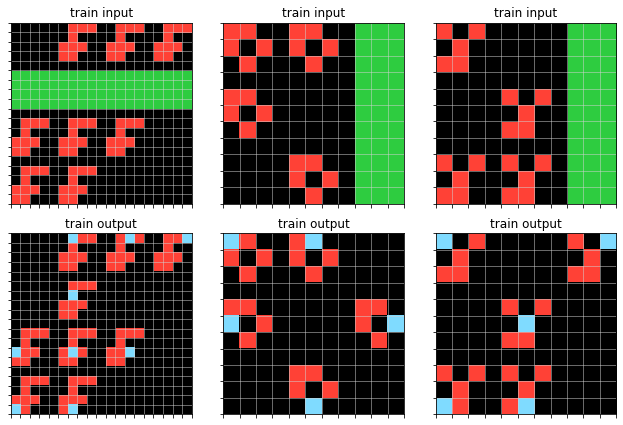

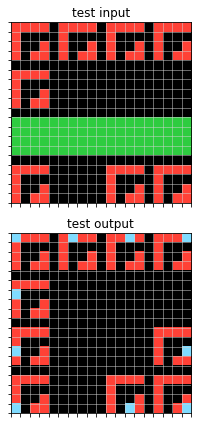

In [7]:
plot_task(eval_tasks[7])

# Check input / output shape distirbution

In [0]:
def get_dataset_shapes(dataset):
  """
  Returns dataset board shapes. 
  """

  shape_0 = []
  shape_1 = []
  
  # check every task
  for task in dataset:
    boards = get_task_boards(task) # get all boards
    shape_0 += [board.shape[0] for board in boards]
    shape_1 += [board.shape[1] for board in boards]
  
  return shape_0, shape_1

def get_task_boards(task, threshold_shape=(np.inf, np.inf), pad=None, test=False):
  """
  Get the training / testing boards of every example in a specific task. 

  Args: threshold_shape --> threshold shape for which 
  biggger samples won't be returned. 
  pad --> functional padding function to pad boards with (up tp threshold_size).
  test --> bool, whether a test task or not. for output of task example.
  """
  
  boards = []

  # train boards
  for example in task['train']:
    input_board = np.array(example['input'])
    output_board = np.array(example['output'])

    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1])):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  # test boards
  for example in task['test']:
    input_board = np.array(example['input'])

    if not test: # check if test example
      output_board = np.array(example['output'])
    
    # check whether the board is smaller then threshold shape
    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1]) and (not test)):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  return boards

def pad(mat, output_shape, padder=0):
  """
  Pad a matrix with padder up to output_shape. Insert matrix at upper left corner.
  
  Args:
  mat - np.array matrix of rank 2
  output_shape - tuple 
  padder - int
  """

  output_board = np.zeros(shape=output_shape) + padder # create output board and pad it

  # get input shape
  input_rows = mat.shape[0]
  input_cols = mat.shape[1]

  # if random=False, insert input matrix in upper left corner
  output_board[:input_rows, :input_cols] = mat
  return output_board

def random_pad(mat, output_shape, padder=0):
  """
  Pad a matrix with padder up to output_shape. Insert the matrix at a random location
  
  Args:
  mat - np.array matrix of rank 2
  output_shape - tuple 
  padder - int
  seed - int
  """

  output_board = np.zeros(shape=output_shape) + padder # create output board and pad it

  # get input shape
  input_rows = mat.shape[0]
  input_cols = mat.shape[1]

  # insert mat at a random loacation
  # get random location
  start_row = np.random.randint(output_shape[0] - input_rows)
  start_col = np.random.randint(output_shape[1] - input_cols)
  # insert
  output_board[start_row:start_row+input_rows, start_col:start_col+input_cols] = mat

  return output_board

In [0]:
train_shape_0, train_shape_1 = get_dataset_shapes(training_tasks)
eval_shape_0, eval_shape_1 = get_dataset_shapes(eval_tasks)

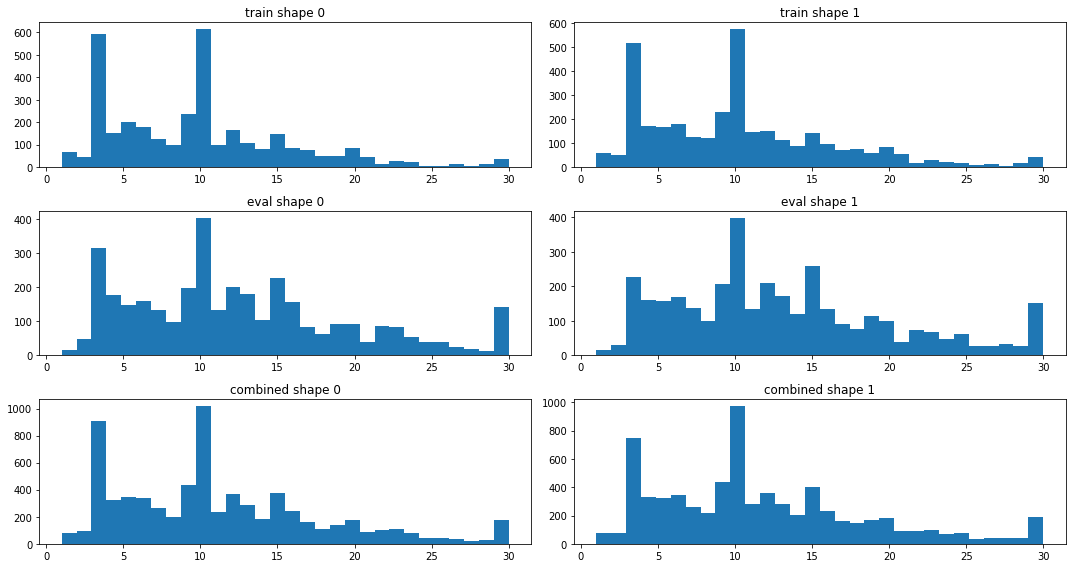

In [10]:
## plot
plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.hist(train_shape_0, bins=30)
plt.title("train shape 0")
plt.subplot(3,2,2)
plt.hist(train_shape_1, bins=30)
plt.title("train shape 1")
plt.subplot(3,2,3)
plt.hist(eval_shape_0, bins=30)
plt.title("eval shape 0")
plt.subplot(3,2,4)
plt.hist(eval_shape_1, bins=30)
plt.title("eval shape 1")
plt.subplot(3,2,5)
plt.hist(eval_shape_0 + train_shape_0, bins=30)
plt.title("combined shape 0")
plt.subplot(3,2,6)
plt.hist(eval_shape_1 + train_shape_1, bins=30)
plt.title("combined shape 1")
plt.tight_layout()
plt.show()

## Prepare data for learning pattern features

In [0]:
BOARD_SIZE = (16,16) # board upperbound size

# get all boards
training_boards = []
for task in training_tasks:
  training_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

  # augment training set
  training_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad)
  training_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad)

eval_boards = []
for task in eval_tasks:
  eval_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

  # augment eval set
  eval_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad)
  eval_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad)
  

test_boards = []
for task in test_tasks:
  test_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad, test=True)

  # augment test set
  test_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad, test=True)
  test_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=random_pad, test=True)

all_boards = training_boards+eval_boards+test_boards

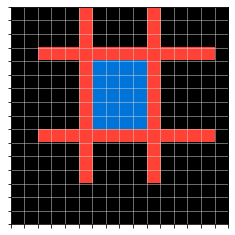

In [12]:
fig, ax = plt.subplots(1,1)
plot_board(test_boards[6], ax)

## Data augmentation

In [0]:
def get_rotated_views(board):
  """
  Turns a board 90 deg counter clockwise 3 times. Returns a list length 4 with all the rotated views including the original one.
  """

  rotates = [board]
  for i in range(3):
    board = np.rot90(board)
    rotates.append(board)
  
  return rotates

def get_rotated_data_pairs(rotated_views):
  """
  Creates all the possible pairs out of the rotated views tensor and labels them. If a1..a4 are rotated vies (A.C.W) of a1, returns labels according to:
   - (a1, a1) = 1 --> same board
   - (a1, a2) = 2 --> 90 a.c.w rotate
   - (a1, a3) = 3 --> 180 rotate
   - (a1, a4) = 4 --> 270 a.c.w rotate
   - ...
   - (a3, a4) = 2 --> 90 a.c.w rotate

  Args:
  rotated_views = a list of 4 rotated views of the board

  Returns:
  pairs: a list of tuples of boards
  labels: a list of labels matching each pair
  """

  # stopping rule
  if rotated_views == []:
    return [], []

  anchor = rotated_views[0]  # select board to compare with 
  pairs, labels = [], []
  label = 1 # init label

  # iterate over all remaining examples
  for view in rotated_views:
    pairs.append((anchor, view))
    labels.append(label)
    label += 1 # update label, views rotate a.c.w
  
  next_pairs, next_labels = get_rotated_data_pairs(rotated_views[1:]) # recursive call

  return pairs + next_pairs, labels + next_labels

def get_binary_board(board):
  """
  Returns a binary board. Every non 0 value becomes 1. 0 stays 0.
  """

  return (board != 0).astype('int32')


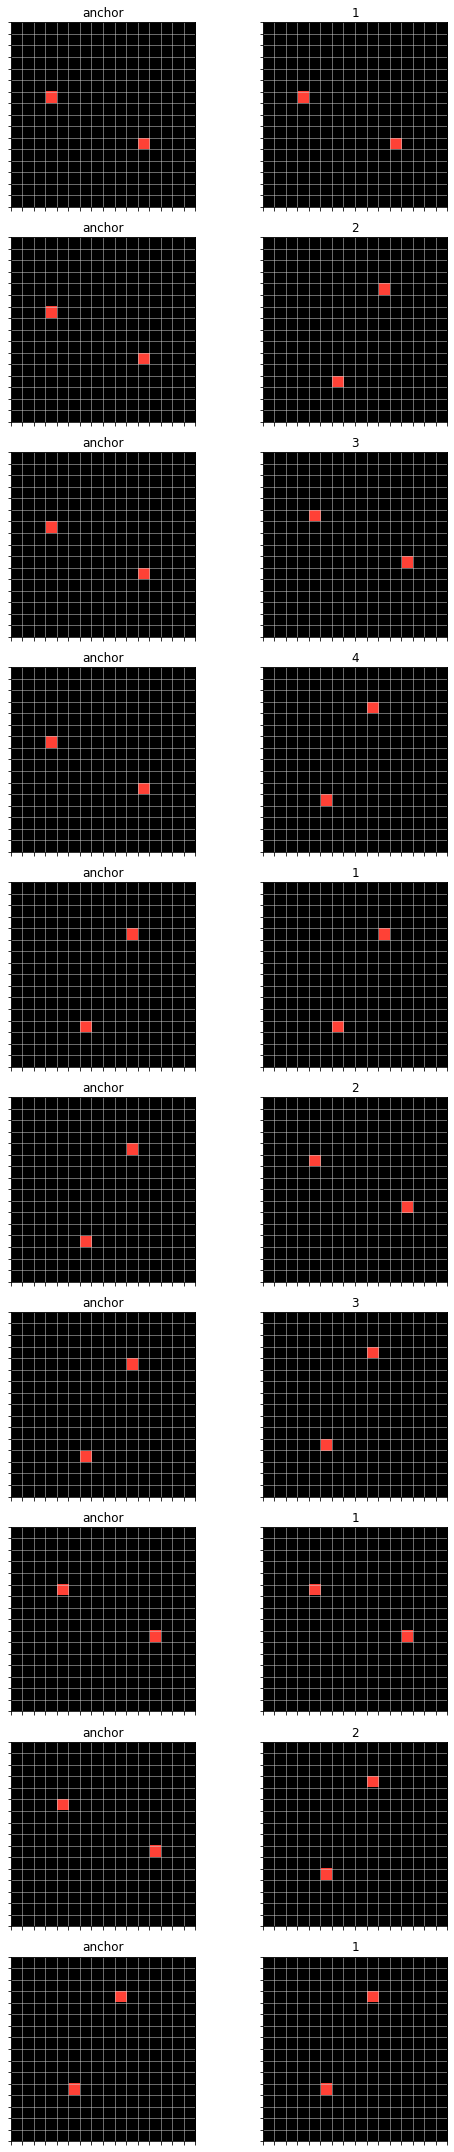

In [14]:
# test it
r = get_rotated_views(test_boards[7])
pairs, labels = get_rotated_data_pairs(r)
plot_board_pairs(pairs, labels)

# Siamese networks architecture

In [0]:
from tensorflow.keras.layers import Conv2D, Lambda, Dense, Flatten, MaxPool2D, Input, BatchNormalization

def get_siamese_networks_model(input_shape):
  """
  Creates siamese networks model. ref paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
  """

  # define input vectors
  input1 = Input(input_shape)
  input2 = Input(input_shape)

  # define model
  model = tf.keras.models.Sequential()

  # stack layers
  model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape, padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9)) ##
  model.add(MaxPool2D(pool_size=(2,2), padding='same'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(MaxPool2D(pool_size=(2,2), padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))

  # flatten
  model.add(Flatten())

  # dense
  model.add(Dense(512, activation='sigmoid'))
  model.add(BatchNormalization(momentum=0.9)) ##

  # compute the two feature vectors
  v1 = model(input1)
  v2 = model(input2)

  # compute L1 loss
  L1_Layer = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))
  L1_diff = L1_Layer([v1, v2])

  # compute probs
  probs = Dense(5, activation='softmax')(L1_diff)

  siamese_net = tf.keras.Model(inputs=[input1, input2], outputs=probs)
  siamese_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  return siamese_net

In [0]:
sn = get_siamese_networks_model([*BOARD_SIZE, 1])

In [17]:
sn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          1186432     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential[1][0]             

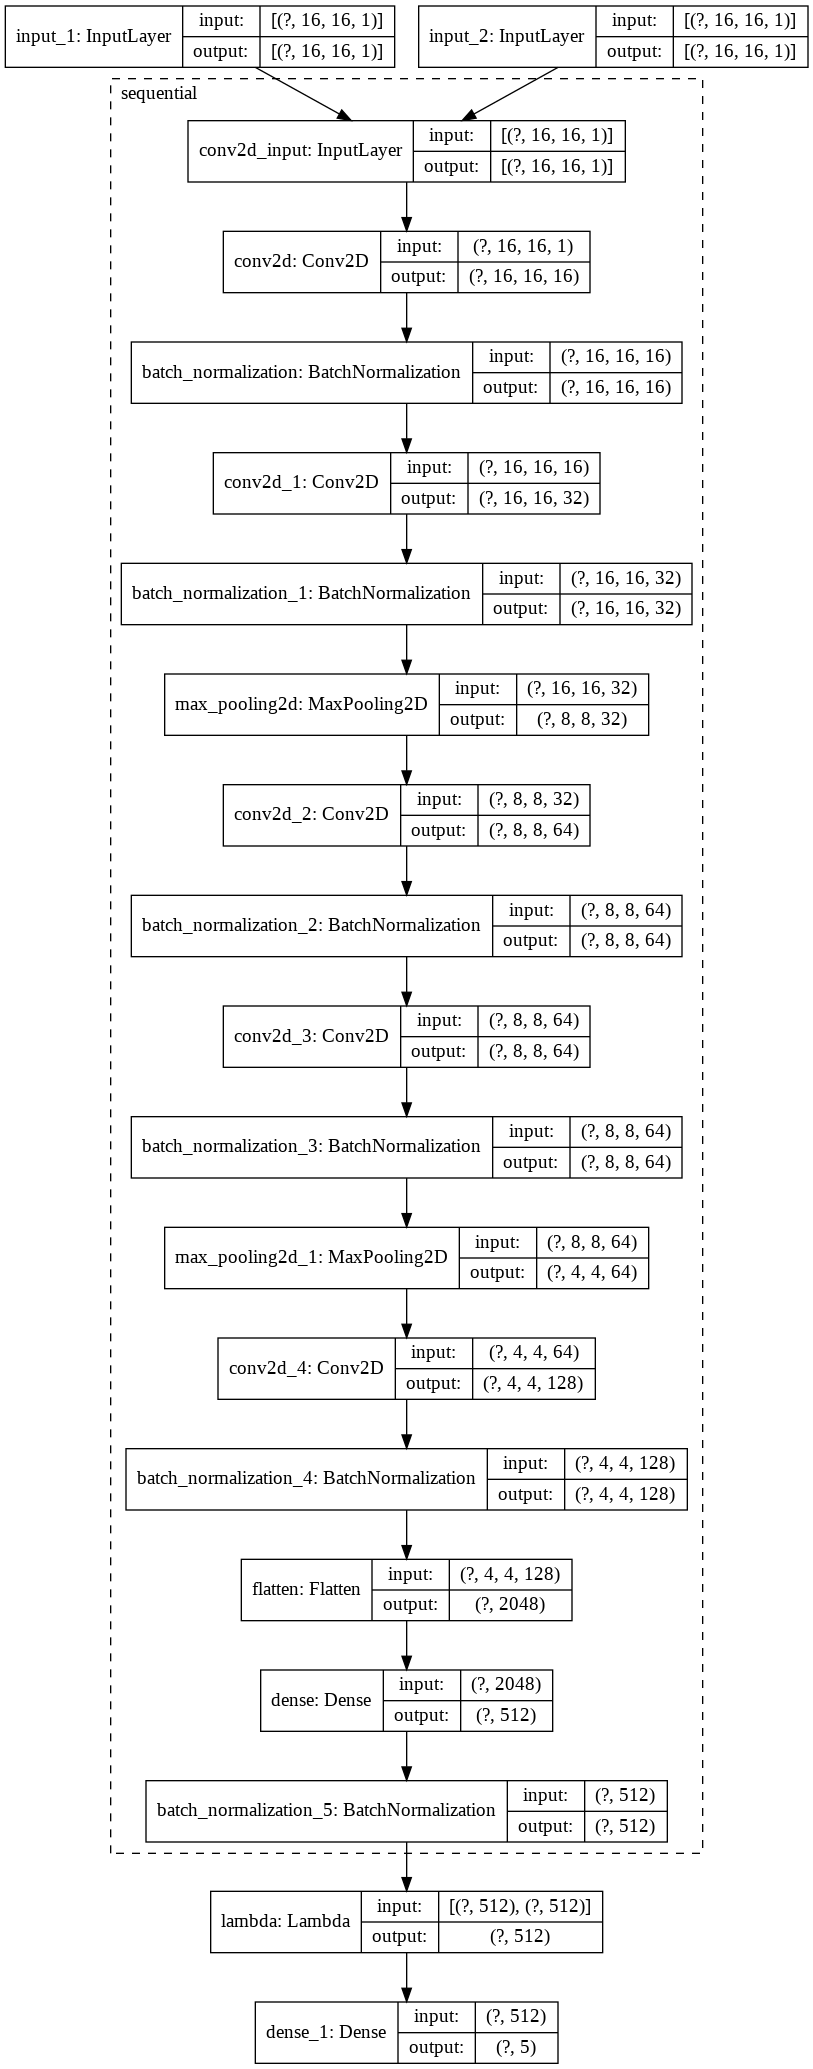

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(sn, to_file='model.png', show_shapes=True, expand_nested=True)

# Create dataset

In [0]:
from sklearn.preprocessing import OneHotEncoder

def model_shape_board(board):
  """
  Reshapes board for moedl digestion. shape [*BOARD_SIZE, 1]
  """
  return board.reshape([*BOARD_SIZE, 1])

def plotting_shape_board(board):
  """
  Reshapes the board for plotting. shape [*BOARD_SIZE]
  """
  return board.reshape([*BOARD_SIZE])

def get_all_pairs_reshaped(board, all_boards):
  """
  Creates a list of pairs of data for the board and reshapes the boards to shape [*BOARD_SHAPE, 1] for nn digestion. For all the possible rotates and a false match

  Args:
  board - np.array
  all_boards - all the other boards on the dataset not including this one

  Returns:
  a list of 5 tuples, 4 for the rotation part and 1 for a false match
  """

  rotated_views = get_rotated_views(board)
  rotated_pairs, rotated_labels = get_rotated_data_pairs(rotated_views)
  rotated_pairs = [(model_shape_board(t[0]), model_shape_board(t[1])) for t in rotated_pairs] # reshape boards

  # create false match pair
  different_board = all_boards[np.random.randint(len(all_boards))] # generate random example
  false_label = 0

  return rotated_pairs + [[board.reshape([*BOARD_SIZE, 1]), different_board.reshape([*BOARD_SIZE, 1])]], rotated_labels + [false_label]

def get_dataset_from_lists(pair_list, label_list, for_encoder=False):
  """
  Creates an x,y dataset from a list of pairs and a list of labels. One hot encode labels

  Args:
  pair list: a list of pairs of images
  label list: a list of ints - labels
  for_encoder: bool - determains if the dataset if for the encoder

  Retrurns:
  x - [x1, x2] a list of two numpy array, each of shape [n_samples, *BOARD_SHAPE, 1] containing stacked inputs of one of the siamese twins OR only x1 if for encoder
  y - one hot labels, only for siamese networks
  """

  # prepare x
  pairs_stacked = np.stack(pair_list)
  x1 = pairs_stacked[:,0,:,:] # get one column of inputs
  x2 = pairs_stacked[:,1,:,:] # get the second one
  x = [x1, x2]

  # prepare y
  ohe = OneHotEncoder(sparse=False) # sparse = false is super importent!!
  stacked_labels = np.stack(label_list).reshape([-1,1]) # stack and reshape label
  y = ohe.fit_transform(stacked_labels)

  # if the dataset is for the decoder return only one column of images
  if not for_encoder:
    return x, y
  
  else:
    return x1
  


In [20]:
%%time
BATCH_SIZE = 64

# binirize all boards
all_boards_binary = map(get_binary_board, all_boards) ### use all!!!

# create a list of all boards augmentation data
pair_list = []
label_list = []

# iterate over all boards
for i, board in enumerate(all_boards_binary):
  board_pairs, board_labels = get_all_pairs_reshaped(board, all_boards[i:]) # augment example. use only boards from here onward
  pair_list += board_pairs
  label_list += board_labels

## create dataset
x, y = get_dataset_from_lists(pair_list, label_list)

CPU times: user 3.27 s, sys: 528 ms, total: 3.8 s
Wall time: 3.72 s


## Training siamese networks

In [21]:
hist = sn.fit(x=x, y=y, epochs=30, steps_per_epoch=100, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.2)

Epoch 1/30
100/100 [==============================] - 4s 36ms/step - loss: 0.4150 - categorical_accuracy: 0.8602 - val_loss: 0.9369 - val_categorical_accuracy: 0.8493
Epoch 2/30
100/100 [==============================] - 3s 31ms/step - loss: 0.1440 - categorical_accuracy: 0.9553 - val_loss: 0.9495 - val_categorical_accuracy: 0.8381
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 0.1096 - categorical_accuracy: 0.9675 - val_loss: 0.9356 - val_categorical_accuracy: 0.8440
Epoch 4/30
100/100 [==============================] - 3s 30ms/step - loss: 0.1006 - categorical_accuracy: 0.9697 - val_loss: 0.9546 - val_categorical_accuracy: 0.8402
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.0763 - categorical_accuracy: 0.9781 - val_loss: 0.8861 - val_categorical_accuracy: 0.8708
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.0781 - categorical_accuracy: 0.9756 - val_loss: 0.9585 - val_categorical_accuracy: 0.841

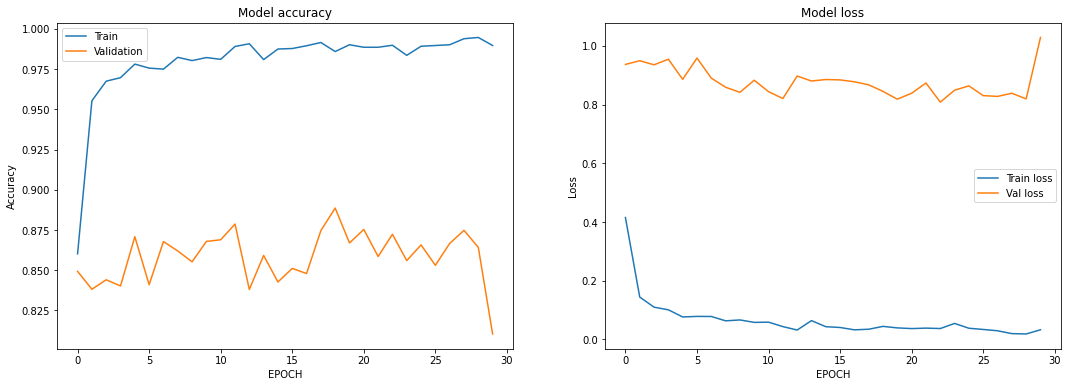

In [22]:
display_training_curves(hist.history, metric='categorical_accuracy', with_val=True)

# Board generator (decoder) architecture

In [0]:
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, Reshape

def get_encoder_from_siamese(siamese):
  """
  Creates a board encoder from the siamese networks model. Maps board --> feature vector of dim 512
  """

  # create encoder from all layers up to dense
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.InputLayer(input_shape=[*BOARD_SIZE, 1]),
                                      siamese.layers[2] # all sequential layers from siamese networks model
  ])

  return model

def get_decoder(siamese, copy_encoder_weights=True):
  """
  Creates a decoder from siamese netwok model. Maps feature vector of dim 512 --> board. 
  Same architecture from encoder is preserved
  """

  # build model
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.InputLayer(input_shape=[512]),
                                      Dense(2048, activation='linear'), # projection
                                      BatchNormalization(momentum=0.9), 
                                      Reshape(target_shape=(4,4,128)),
                                      Conv2DTranspose(64, kernel_size=(3,3), activation='relu', padding='same'),
                                      BatchNormalization(momentum=0.9), 
                                      UpSampling2D(size=(2,2)),
                                      Conv2DTranspose(64, kernel_size=(3,3), activation='relu', padding='same'),
                                      BatchNormalization(momentum=0.9), 
                                      Conv2DTranspose(32, kernel_size=(3,3), activation='relu', padding='same'),
                                      BatchNormalization(momentum=0.9), 
                                      UpSampling2D(size=(2,2)),
                                      Conv2DTranspose(16, kernel_size=(3,3), activation='relu', padding='same'),
                                      BatchNormalization(momentum=0.9), 
                                      Conv2DTranspose(1, kernel_size=(3,3), activation='relu', padding='same')
  ])

  if copy_encoder_weights:
    # set weights from the encoder
    enc_layers = siamese.layers[2].layers # get encoder layers
    
    for i, layer in enumerate(model.layers[::-1]):
      if(2 >= len(layer.weights) > 0): # trainable layer and not BN layer
        if layer.weights[0].shape[0] < 100: # deconv layers
          enc_layer_weigths = enc_layers[i].get_weights() # get weights from encoder
          bias = np.zeros(layer.get_weights()[1].shape) # init new bias
          w = enc_layer_weigths[0].transpose([1,0,2,3]) # transpose weights
          layer.set_weights([w, bias]) # set decoder weights

        else:
          # dense layer
          enc_layer_weigths = enc_layers[i].get_weights() # get weights from encoder
          bias = np.zeros(layer.get_weights()[1].shape) # init new bias
          w = enc_layer_weigths[0].transpose() # transpose weights
          layer.set_weights([w, bias]) # set decoder weights

  # compile
  model.compile(loss=pixelwise_error_loss, optimizer='adam', metrics='mse')
  return model

def pixelwise_error_loss(y_true, y_pred):
  """
  Custom loss function. Pixelwise error from the true image. ||y_true - y_pred||
  """

  return tf.keras.backend.sum((y_true - y_pred) ** 2)


In [0]:
dec = get_decoder(sn, copy_encoder_weights=True)

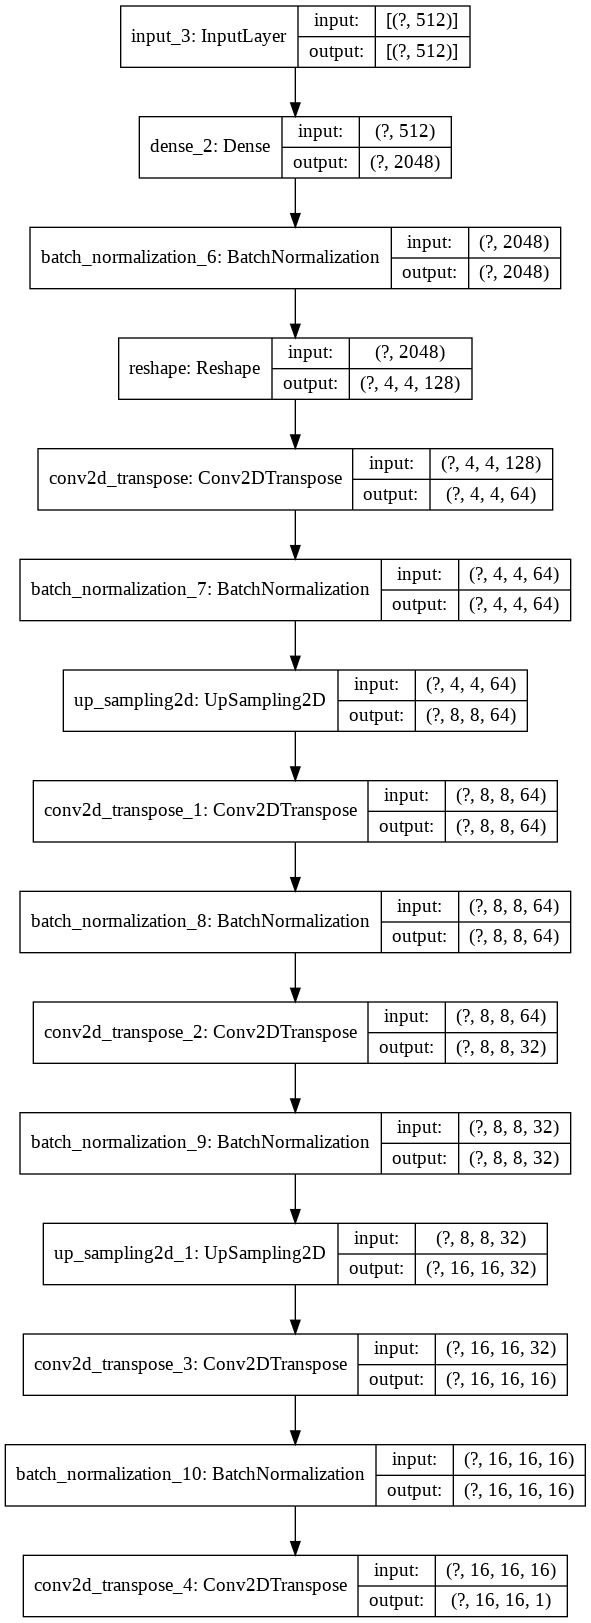

In [25]:
plot_model(dec, show_shapes=True)

## Decoder dataset


In [0]:
def get_decoder_dataset(siamese, encoder_dataset):
  """
  Creates the decoder dataset from the encoder.
  
  Args:
  siamese - siamese model to extract encoder from
  encoder dataset - boards to encoder to feature vectors

  Returns:
  x - boards feature vectors, predicted by encoder
  y - boards 
  """
  
  enc = get_encoder_from_siamese(siamese) # fetch encoder

  # build dataset
  x = enc.predict(encoder_dataset) # get feature vectors
  y = encoder_dataset # boards to recreate

  return x,y

# create encoder dataset from the old pair and label lists
encoder_dataset = get_dataset_from_lists(pair_list, label_list, for_encoder=True) 

# create decoder dataset from encoder
decoder_x, decoder_y = get_decoder_dataset(sn, encoder_dataset)

In [27]:
hist_decoder = dec.fit(x=decoder_x, y=decoder_y, batch_size=32, shuffle=True, epochs=10, validation_split=0.2)

Epoch 1/10
4686/4686 [==============================] - 21s 4ms/step - loss: 383.5961 - mse: 0.0468 - val_loss: 327.2500 - val_mse: 0.0400
Epoch 2/10
4686/4686 [==============================] - 21s 4ms/step - loss: 296.2484 - mse: 0.0362 - val_loss: 303.6400 - val_mse: 0.0371
Epoch 3/10
4686/4686 [==============================] - 21s 4ms/step - loss: 275.6255 - mse: 0.0336 - val_loss: 297.0070 - val_mse: 0.0363
Epoch 4/10
4686/4686 [==============================] - 20s 4ms/step - loss: 262.3577 - mse: 0.0320 - val_loss: 291.6565 - val_mse: 0.0356
Epoch 5/10
4686/4686 [==============================] - 21s 4ms/step - loss: 251.8987 - mse: 0.0307 - val_loss: 284.4631 - val_mse: 0.0347
Epoch 6/10
4686/4686 [==============================] - 21s 4ms/step - loss: 243.9004 - mse: 0.0298 - val_loss: 279.0938 - val_mse: 0.0341
Epoch 7/10
4686/4686 [==============================] - 21s 4ms/step - loss: 237.0548 - mse: 0.0289 - val_loss: 276.6060 - val_mse: 0.0338
Epoch 8/10
4686/4686 [=====

# Check regular encoder-decoder architecture
## For checking some hyperparameters and deciding which adecoder architecture to use

## Some takeaways:
- adding two sets of randomly padded data helps alot. more doesnt help
- small decoder batch size (4-16) really helps
- adding more neurons to the compressed represantation (512 --> 1024) really helps
- removing the last layers batch normalization really helps
 - removing bn before compressed representation isnt good
- penelizing mistaking 1's for 0's more doesnt help at all
- changing last layer activation to linear and clipping to [0,1] helps to some extent
- chagning middle to relu - really bad!!!
- addind another conv-deconv layer at the beggining helps a little
- adding another conv-deconv layer at the end doesnt help at all
- residual layers....
- more types of data augmentation....


In [0]:
def get_encoder_decoder():
  """
  Create an encoder decoer "normal" architecture
  """

  model = tf.keras.models.Sequential()

  # encoder
  model.add(tf.keras.layers.InputLayer([*BOARD_SIZE, 1]))
  model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(MaxPool2D(pool_size=(2,2), padding='same'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(MaxPool2D(pool_size=(2,2), padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  
  # flatten
  model.add(Flatten())

  # dense representation
  model.add(Dense(1024, activation='sigmoid'))


  # decoder 
  model.add(Dense(2048, activation='linear'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Reshape(target_shape=(4,4,128)))
  model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(BatchNormalization(momentum=0.9))
  model.add(Conv2DTranspose(1, kernel_size=(3,3), activation='linear', padding='same'))
  model.add(Lambda(lambda t: tf.clip_by_value(t, 0, 1)))
  

  # compile
  model.compile(loss=pixelwise_error_loss, optimizer='adam')
  return model

In [0]:
def residual_encoder_block(filter_num, kernel_size, bn_moment):
  
  
  def block(x, filter_num, kernel_size=(3,3), bn_moment=0.9):
    # first layer
    c1 = Conv2D(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(x)
    c1 = BatchNormalization(momentum=bn_moment)(c1)

    # second layer
    c2 = Conv2D(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(c1)
    c2 = BatchNormalization(momentum=bn_moment)(c2)

    # third layer
    c3 = Conv2D(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(c2)
    c3 = BatchNormalization(momentum=bn_moment)(c3)

    # residual connection
    res = c1 + c3

    return res

  return lambda x: block(x, filter_num, kernel_size, bn_moment)

def residual_decoder_block(filter_num, kernel_size, bn_moment, first=False, last=False):
  
  
  def block(x, filter_num, kernel_size=(3,3), bn_moment=0.9):
    
    # first layer
    if first:
      dc1 = Dense(4*4*filter_num, activation='linear')(x) # num neurons is dependent upon the number of blocks
      dc1 = BatchNormalization(momentum=bn_moment)(dc1)
      dc1 = Reshape(target_shape=(4,4,filter_num))(dc1) # reshaping is dependent upon the number of blocks
    
    else:
      dc1 = Conv2DTranspose(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(x)
      dc1 = BatchNormalization(momentum=bn_moment)(dc1)

    # second layer
    dc2 = Conv2DTranspose(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(dc1)
    dc2 = BatchNormalization(momentum=bn_moment)(dc2)

    # third layer
    dc3 = Conv2DTranspose(filter_num, kernel_size=kernel_size, activation='relu', padding='same')(dc2)
    dc3 = BatchNormalization(momentum=bn_moment)(dc3)

    # residual connection
    res = dc1 + dc3

    return res

  return lambda x: block(x, filter_num, kernel_size, bn_moment)


def get_encoder_decoder1():
  """
  Create an encoder decoer "normal" architecture, with residual connections
  """
  inp = tf.keras.layers.Input([*BOARD_SIZE, 1])
  
  # encoder
  block1 = residual_encoder_block(16, kernel_size=(3,3), bn_moment=0.9)(inp)
  mp1 = MaxPool2D(pool_size=(2,2))(block1)

  block2 = residual_encoder_block(32, kernel_size=(3,3), bn_moment=0.9)(mp1)
  mp2 = MaxPool2D(pool_size=(2,2))(block2)

  block3 = residual_encoder_block(64, kernel_size=(3,3), bn_moment=(0.9))(mp2)

  # flatten
  flat = Flatten()(block3)

  # dense representation
  dense = Dense(1024, activation='sigmoid')(flat)
  dense = BatchNormalization(momentum=0.9)(dense)


  # decoder 

  # first_block
  block1 = residual_decoder_block(16, kernel_size=(3,3), bn_moment=0.9, first=True)(dense)
  us1 = UpSampling2D(size=(2,2))(block1)

  block2 = residual_decoder_block(32, kernel_size=(3,3), bn_moment=0.9)(us1)
  us2 = UpSampling2D(size=(2,2))(block2)

  block3 = residual_decoder_block(64, kernel_size=(3,3), bn_moment=0.9)(us2)

  output = Conv2D(1, kernel_size=(1,1), activation='sigmoid')(block3)

  model = tf.keras.Model(inputs=inp, outputs=output)
  

  # compile
  model.compile(loss=pixelwise_error_loss, optimizer='adam')
  return model

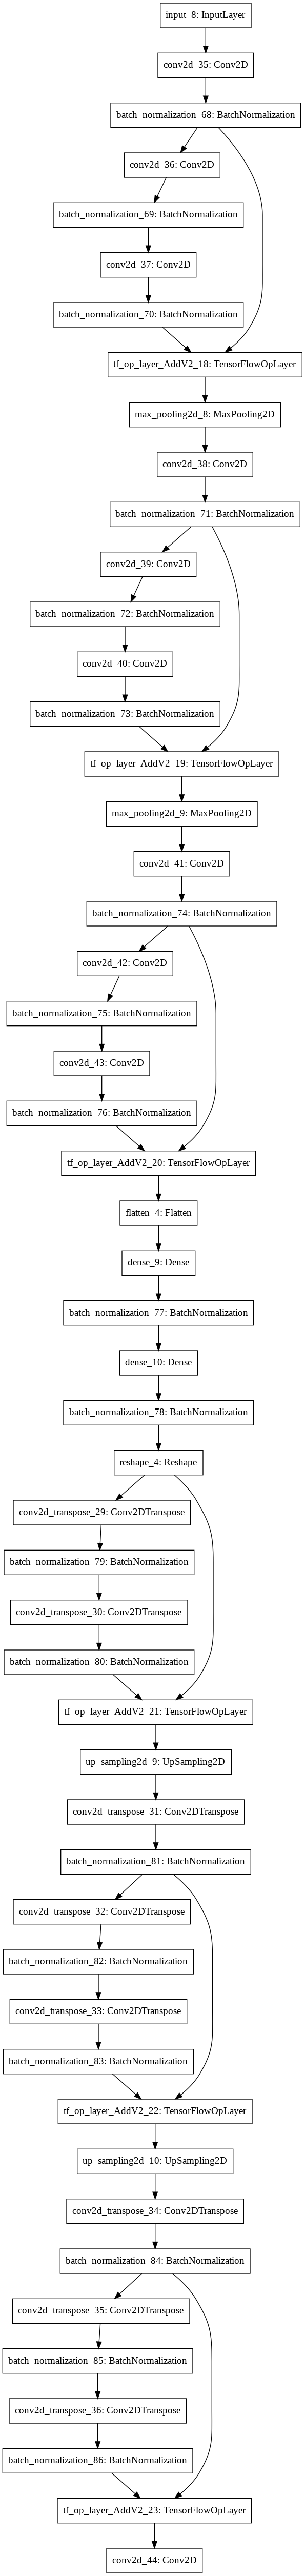

In [38]:
ed = get_encoder_decoder1()
plot_model(ed)

In [39]:
ed_hist = ed.fit(x=decoder_y, y=decoder_y, batch_size=8, shuffle=True, epochs=20, validation_split=0.2) # get image --> predict image

Epoch 1/20
18744/18744 [==============================] - 150s 8ms/step - loss: 62.7228 - val_loss: 37.7648
Epoch 2/20
18744/18744 [==============================] - 150s 8ms/step - loss: 34.4133 - val_loss: 23.4346
Epoch 3/20
18744/18744 [==============================] - 149s 8ms/step - loss: 24.3740 - val_loss: 16.8014
Epoch 4/20
18744/18744 [==============================] - 147s 8ms/step - loss: 19.4020 - val_loss: 14.1253
Epoch 5/20
18744/18744 [==============================] - 148s 8ms/step - loss: 16.4204 - val_loss: 11.9732
Epoch 6/20
18744/18744 [==============================] - 149s 8ms/step - loss: 14.2051 - val_loss: 10.3670
Epoch 7/20
18744/18744 [==============================] - 149s 8ms/step - loss: 12.6584 - val_loss: 9.2605
Epoch 8/20
18744/18744 [==============================] - 148s 8ms/step - loss: 11.4066 - val_loss: 8.8512
Epoch 9/20
18744/18744 [==============================] - 150s 8ms/step - loss: 10.3336 - val_loss: 8.0183
Epoch 10/20
18744/18744 [======

In [0]:
plot_model(ed, expand_nested=True, show_shapes=True)

In [0]:
board = model_shape_board(all_boards[15])
boards = np.stack([board,board])
e = get_encoder_from_siamese(sn).predict(boards)
d = decoder.predict(e)
p = plotting_shape_board(d[0])
board = plotting_shape_board(board)

In [0]:
fig, axs = plt.subplots(1,2)
plot_board(board, axs[0])
plot_board(p, axs[1])

# Interleaved training (decoder/encoder/deocoder..)

In [0]:
def copy_decoder_to_siamese(siamese, decoder):
  """
  Copys the weights from the decoder to the siamese networks model
  """

  decoder_layers = decoder.layers # get decoder layers
  siamese_layers = siamese.layers[2].layers # siamese encoder layers

  for i, layer in enumerate(decoder_layers[::-1]):
      if(2 >= len(layer.weights) > 0): # trainable layer and not BN layer
        if layer.weights[0].shape[0] < 100: # deconv layers
          decoder_layer_weigths = layer.get_weights() # get weights from decoder
          bias = np.zeros(siamese_layers[i].get_weights()[1].shape) # init new bias
          w = decoder_layer_weigths[0].transpose([1,0,2,3]) # transpose weights
          siamese_layers[i].set_weights([w, bias]) # set siamese weights

        else:
          # dense layer
          decoder_layer_weigths = layer.get_weights() # get weights from decoder
          bias = np.zeros(siamese_layers[i].get_weights()[1].shape) # init new bias
          w = decoder_layer_weigths[0].transpose() # transpose weights
          siamese_layers[i].set_weights([w, bias]) # set siamese weights


def copy_siamese_to_decoder(siamese, decoder):
  """
  Copys the weights from the siamese networks model to the decoder
  """

  decoder_layers = decoder.layers # get decoder layers
  siamese_layers = siamese.layers[2].layers # siamese encoder layers

  for i, layer in enumerate(decoder_layers[::-1]):
      if(2 >= len(layer.weights) > 0): # trainable layer and not BN layer
        if layer.weights[0].shape[0] < 100: # deconv layers
          siamese_layer_weigths = siamese_layers[i].get_weights() # get weights from siamese encoder
          bias = np.zeros(layer.get_weights()[1].shape) # init new bias
          w = siamese_layer_weigths[0].transpose([1,0,2,3]) # transpose weights
          layer.set_weights([w, bias]) # set decoder weights

        else:
          # dense layer
          siamese_layer_weigths = siamese_layers[i].get_weights() # get weights from siamese encoder
          bias = np.zeros(layer.get_weights()[1].shape) # init new bias
          w = siamese_layer_weigths[0].transpose() # transpose weights
          layer.set_weights([w, bias]) # set decoder weights


In [0]:
# create new models with same weights
EPOCHS = 30
sn = get_siamese_networks_model([*BOARD_SIZE, 1])
decoder = get_decoder(sn, copy_encoder_weights=False)

In [0]:
from tqdm import tqdm
SN_BATCH_SIZE = 64
DEC_BATCH_SIZE = 4
DATA_SPLIT = 5
SN_STEPS_PER_EPOCH = len(x) // SN_BATCH_SIZE
DEC_STEPS_PER_EPOCH = len(decoder_x) // DEC_BATCH_SIZE

# even fancier training loop
for i in range(EPOCHS):
  print("training... epoch num: {}".format(i))

  for i in range(40):
    # train siamese
    _ = sn.fit(x=x, y=y, epochs=1, batch_size=SN_BATCH_SIZE, shuffle=True, steps_per_epoch=(780//DATA_SPLIT))
    
    # copy weights
    copy_siamese_to_decoder(sn, decoder)

    # get new decoder dataset
    decoder_x, decoder_y = get_decoder_dataset(sn, encoder_dataset) # encoder dataset is the same as before

    # train decoder
    _ = decoder.fit(x=decoder_x, y=decoder_y, epochs=1, batch_size=DEC_BATCH_SIZE, shuffle=True, steps_per_epoch=(24000//DATA_SPLIT)) #### WOW!!! use smaller batch size, WOHOOO!!

    # copy weights
    copy_decoder_to_siamese(sn, decoder)